<a href="https://colab.research.google.com/github/samantha96/Prejudice-Remover-Regularizer-Implementation/blob/main/Xuehan_PRLR_0321_onehot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch as t
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd 
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
student_perf_label= pd.read_csv('/Users/mihikaghaisas/Desktop/Purdue/Courses/CS 578/Project/data/studentperf_label.csv')
kiva_label = pd.read_csv('/Users/mihikaghaisas/Desktop/Purdue/Courses/CS 578/Project/data/kiva_label.csv')

student_perf_onehot= pd.read_csv('/Users/mihikaghaisas/Desktop/Purdue/Courses/CS 578/Project/data/studentperf_onehot.csv')
kiva_onehot = pd.read_csv('/Users/mihikaghaisas/Desktop/Purdue/Courses/CS 578/Project/data/kiva_onehot.csv')


In [73]:
def split_data(X, y):
    if y.shape[0] == 2:
        return train_test_split(X, y, test_size=0.50, random_state=42)
    else :
        return train_test_split(X, y, test_size=0.30, random_state=42)
def threshold(df, col):
    med = df[col].median()
    df[col] = df[col].apply(lambda x: '1' if int(x) > med else '0') #if high loan amount label is 1   
    return df

def processing(df, sensitive_feature, target_variable, flag):
    #lose sensitive feature
    df = df[df[sensitive_feature] == flag]
    X = t.from_numpy(np.array(df.drop(columns=[target_variable]))).to(t.float32)
    #print(X)
    y = t.from_numpy(np.array(df[target_variable]).astype('float32')).reshape(X.shape[0], 1)

    return split_data(X, y) #returns a 4 values with data split into test and train containing  only the flagged sensitive feature  

# LABEL ENCODING

## 1.Data Preprocessing

In [6]:
kiva_label

,funded_amount,loan_amount,sector,country_code,currency,partner_id,term_in_months,lender_count,borrower_genders,repayment_interval
0,300.0,300.0,6,51,39,247.0,12.0,12,0,1
1,150.0,150.0,13,27,19,334.0,43.0,6,0,0
2,200.0,200.0,1,51,39,247.0,11.0,8,0,1
3,400.0,400.0,6,51,39,245.0,14.0,16,0,2
4,200.0,200.0,0,27,19,334.0,43.0,8,0,0
...,...,...,...,...,...,...,...,...,...,...
548111,0.0,25.0,0,53,52,58.0,13.0,0,0,2
548112,0.0,25.0,0,53,52,58.0,13.0,0,0,2
548113,25.0,25.0,0,30,21,138.0,13.0,1,0,2
548114,0.0,25.0,0,30,21,138.0,13.0,0,0,2


In [7]:
#finding loan amount avg: 
mean = kiva_label["loan_amount"].mean()
med = kiva_label["loan_amount"].median()
std =  kiva_label["loan_amount"].std()
print(f"Mean is {mean}")
print(f"Median is {med}")
print(f"Standard dev is {std}")

#going with the median since the standard deviation is so high

Mean is 631.0293806420539
Median is 450.0
Standard dev is 815.1155434167922


In [8]:
student_perf_label.drop(columns={'Unnamed: 0'}, inplace = True)
student_perf_label

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,7,73,1,0,1,2,3,0,1,2,1,67
1,19,64,8,59,1,2,2,2,4,0,0,1,0,61
2,24,98,7,91,2,2,2,2,4,0,2,2,1,74
3,29,89,8,98,2,1,2,2,4,0,1,1,1,71
4,19,92,6,65,2,3,2,0,4,0,0,2,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,25,69,7,76,2,1,0,2,2,0,1,2,0,68
6374,23,76,8,81,2,3,1,0,2,0,1,2,0,69
6375,20,90,6,65,1,3,1,2,2,0,2,2,0,68
6376,10,86,6,91,0,2,1,2,3,0,1,0,0,68


In [9]:
student_perf_label['Family_Income'].nunique()

3

In [10]:
#finding loan amount avg: 
mean = student_perf_label["Exam_Score"].mean()
med = student_perf_label["Exam_Score"].median()
std =  student_perf_label["Exam_Score"].std()
print(f"Mean is {mean}")
print(f"Median is {med}")
print(f"Standard dev is {std}")

#going with the median since median and mean are the same

Mean is 67.25211665098777
Median is 67.0
Standard dev is 3.9142165067512247


### Process training dataset

In [11]:
kiva_label= threshold(kiva_label, 'loan_amount')
X_train_female_kiva, X_test_female_kiva, y_train_female_kiva, y_test_female_kiva  = processing(kiva_label, 'borrower_genders', 'loan_amount', 0)
X_train_male_kiva, X_test_male_kiva, y_train_male_kiva, y_test_male_kiva  = processing(kiva_label, 'borrower_genders', 'loan_amount', 1)

student_perf_label = threshold(student_perf_label, 'Exam_Score')
X_train_female_st, X_test_female_st, y_train_female_st, y_test_female_st  = processing(student_perf_label, 'Gender', 'Exam_Score', 0)
X_train_male_st, X_test_male_st, y_train_male_st, y_test_male_st  = processing(student_perf_label, 'Gender', 'Exam_Score', 1)


In [46]:
# Define a logistic regression model using PyTorch's nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, flag=0):
        # Call the parent constructor to initialize the nn.Module
        super(LogisticRegression, self).__init__()

        # Define a linear transformation layer (weights and bias) for the model.
        # `x_test_female.shape[1]` specifies the number of input features, and `out_features=1` indicates a single output for binary classification.
        # The bias term is included by setting bias=True, allowing the model to learn an intercept.
        self.flag= flag
        self.w =0
        if self.flag == 0:
            self.w = nn.Linear(X_train_female_kiva.shape[1], out_features=1, bias=True)
        else:
            self.w = nn.Linear(X_train_female_st.shape[1], out_features=1, bias=True)
        

        # Initialize a sigmoid activation function, which will be used to convert logits to probabilities.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Define the forward pass for the model.
        # Apply the linear transformation to the input `x`.
        w = self.w(x)

        # Apply the sigmoid function to the output of the linear layer.
        # This converts the logits (raw output of the linear layer) to probabilities in the range (0, 1).
        output = self.sigmoid(w)

        # Return the output probabilities.
        return output


## 2.Define PRLR: 
### Object funtion: Loss function(negative log-likelihood) + Prejudice Remover Regularizer(mutual information) + l2 Regularizer

In [13]:
class PRLoss():  # Define a class for the probabilistic loss function
    def __init__(self, eta=1.0, flag=0):
        # Initialize the class with a scaling factor eta.
        # The eta parameter can be used to adjust the magnitude of the loss.
        super(PRLoss, self).__init__()
        self.eta = eta  # Set the eta value for scaling the loss.
        self.flag = flag  # Set the flag value, default is 0.


    def forward(self, output_f, output_m):
       

        # The forward method computes the loss based on the outputs for females (output_f) and males (output_m).
        
        # Calculate the number of female and male samples
        N_female = t.tensor(output_f.shape[0])  # Number of female samples
        N_male = t.tensor(output_m.shape[0])      # Number of male samples
        
        # Stack the number of samples for males and females into a tensor
        Dxisi = t.stack((N_male, N_female), axis=0)  # Tensor with shape [2] containing male and female counts

        # Calculate the predicted probabilities for females and males
        y_pred_female = t.sum(output_f)  # Sum of predicted probabilities for females
        y_pred_male = t.sum(output_m)      # Sum of predicted probabilities for males
        
        # Calculate conditional probabilities Pr[y|s]
        P_ys = t.stack((y_pred_male, y_pred_female), axis=0) / Dxisi
        # P_ys now contains the probabilities of y given the gender (s)

        # Calculate overall probability Pr[y]
        P = t.cat((output_f, output_m), 0)  # Concatenate female and male predictions
        P_y = 0
        if self.flag == 0: #kiva dataset
            P_y = t.sum(P) / (X_train_female_kiva.shape[0] + X_train_male_kiva.shape[0])  # Overall probability of y
        else:
            P_y = t.sum(P) / (X_train_female_st.shape[0] + X_train_male_st.shape[0])  # Overall probability of y
        # Calculate the individual terms needed for the loss
        P_s1y1 = t.log(P_ys[1]) - t.log(P_y)  # Log probability for female given positive class
        P_s1y0 = t.log(1 - P_ys[1]) - t.log(1 - P_y)  # Log probability for female given negative class
        P_s0y1 = t.log(P_ys[0]) - t.log(P_y)  # Log probability for male given positive class
        P_s0y0 = t.log(1 - P_ys[0]) - t.log(1 - P_y)  # Log probability for male given negative class

        # Calculate the individual contributions to the loss
        PI_s1y1 = output_f * P_s1y1  # Contribution from female samples in positive class
        PI_s1y0 = (1 - output_f) * P_s1y0  # Contribution from female samples in negative class
        PI_s0y1 = output_m * P_s0y1  # Contribution from male samples in positive class
        PI_s0y0 = (1 - output_m) * P_s0y0  # Contribution from male samples in negative class

        # Sum all contributions to get the final loss
        PI = t.sum(PI_s1y1) + t.sum(PI_s1y0) + t.sum(PI_s0y1) + t.sum(PI_s0y0)
        PI = self.eta * PI  # Scale the loss by eta

        return PI  # Return the computed loss


## 3.Model Validation

### Accuracy

In [108]:
def accuracy(Model_f, Model_m, X_train_female, y_train_female, X_train_male, y_train_male):
    # Generate predictions for female samples using the female model.
    yf_pred = (Model_f(X_train_female) >= 0.5)  # Apply the model and threshold at 0.5 to get binary predictions.
    
    # Generate predictions for male samples using the male model.
    ym_pred = (Model_m(X_train_male) >= 0.5)  # Apply the model and threshold at 0.5 to get binary predictions.
    
    # Calculate accuracy for female predictions.
    accu_f = t.sum(yf_pred.flatten() == y_train_female.flatten()) / X_train_female.shape[0]  
    # Compare predicted labels with actual labels and compute the fraction of correct predictions.
    
    # Calculate accuracy for male predictions.
    accu_m = t.sum(ym_pred.flatten() == y_train_male.flatten()) / X_train_male.shape[0]  
    # Compare predicted labels with actual labels and compute the fraction of correct predictions.

    # Compute the average accuracy across both models.
    accuracy = (accu_f + accu_m) / 2  
    
    # Return the accuracy rounded to four decimal places.
    return round(accuracy.item(), 4)  

    # Print the accuracy percentage.
    print("Accuracy : %.3f" % (accuracy * 100) + '%') 


### CV_score

In [109]:
def CVS(Model_f, Model_m, X_train_female, X_train_male):
    # Generate predictions for female samples using the female model.
    yf_pred = (Model_f(X_train_female) >= 0.5)  # Apply the model and threshold at 0.5 to get binary predictions.
    
    # Generate predictions for male samples using the male model.
    ym_pred = (Model_m(X_train_male) >= 0.5)  # Apply the model and threshold at 0.5 to get binary predictions.
    
    # Count the number of correct predictions for female samples.
    corr_f = t.sum(yf_pred == True)  # Count how many female predictions are True (1).
    
    # Count the number of correct predictions for male samples.
    corr_m = t.sum(ym_pred == True)  # Count how many male predictions are True (1).
    
    # Calculate the probability of predicting income as >50K for females.
    P_y1_s1 = corr_f / X_train_female.shape[0]  # Probability of positive predictions among females.
    
    # Calculate the probability of predicting income as >50K for males.
    P_y1_s0 = corr_m / X_train_male.shape[0]  # Probability of positive predictions among males.
    
    # Calculate the Calder-Verwer discrimination score, which measures the difference in positive prediction probabilities.
    CV_score = t.abs(P_y1_s0 - P_y1_s1)  # Absolute difference between the two probabilities.
    
    # Return the Calder-Verwer discrimination score rounded to four decimal places.
    return round(CV_score.item(), 4)  
    
    # Print the Calder-Verwer discrimination score.
    print ('Calder-Verwer discrimination score: %.4f' % (CV_score.item()))  


## 4.Model implementation: Logistic regression model with PR Regularizer

In [110]:
class PRLR():  # Class definition for a linear model focused on parity regularization.
    def __init__(self, eta=0.0, epochs=3000, lr=0.01, flag=0):
        super(PRLR, self).__init__()  # Call the constructor of the parent class.
        self.eta = eta  # Coefficient for the fairness term in the loss function.
        self.epochs = epochs  # Number of training epochs.
        self.lr = lr  # Learning rate for the optimizer.
        self.flag = flag

    def fit(self, X_train_female, y_train_female, X_train_male, y_train_male):
        # Initialize logistic regression models for females and males.
        model_f = LogisticRegression(self.flag)  # Model for female data.
        model_m = LogisticRegression(self.flag)  # Model for male data.

        # Define the binary cross-entropy loss criterion.
        criterion = nn.BCELoss(reduction='sum')  # Binary cross-entropy loss.

        # Initialize the custom loss function for parity regularization.
        PI = PRLoss(eta=self.eta, flag=self.flag)

        # Set the number of epochs for training.
        epochs = self.epochs

        # Create an optimizer that combines the parameters of both models.
        optimizer = t.optim.Adam(list(model_f.parameters()) + list(model_m.parameters()), self.lr, weight_decay=1e-5)

        # Training loop
        for epoch in range(epochs):
            optimizer.zero_grad()  # Reset gradients for the optimizer.
            
            # Forward pass: compute predictions for both models.
            
            output_f = t.sigmoid(model_f(X_train_female))  # Predictions for female input.
            output_m = t.sigmoid(model_m(X_train_male))  # Predictions for male input.

        
            # Calculate the binary cross-entropy loss for both outputs.
            logloss = criterion(output_f, y_train_female) + criterion(output_m, y_train_male)

            # Calculate the parity regularization loss.
            PIloss = PI.forward(output_f, output_m)

            # Total loss is the sum of log loss and parity regularization loss.
            loss = PIloss + logloss

            # Backward pass: compute gradients.
            loss.backward()

            # Update model parameters using the optimizer.
            optimizer.step()

        # Set models to evaluation mode after training is done.
        model_f.eval()  
        model_m.eval()

        # Calculate accuracy and Calder-Verwer discrimination score.
        accu = accuracy(model_f, model_m, X_train_female, y_train_female, X_train_male, y_train_male)  # Get accuracy.
        cvs = CVS(model_f, model_m, X_train_female, X_train_male)  # Get Calder-Verwer score.

        return accu, cvs  # Return accuracy and Calder-Verwer score.


## 5.change eta and observe the change of accuracy and CV-score

In [18]:
PR = PRLR(eta = 1.0, epochs = 3000, lr = 0.01, flag =0)
t.tensor(PR.fit(X_train_female_kiva,y_train_female_kiva,X_train_male_kiva,y_train_male_kiva)).reshape(2,1)

tensor([[0.6634],
        [0.3792]])

In [19]:
# CVscore: Calder-Verwer discrimination score
# CV score on sample data: Pr[y=1 | S=0] - Pr[y=1 | S=1]
# For sample training data

#kiva:
kiva_label['loan_amount'] = kiva_label['loan_amount'].astype(int)
high_f = kiva_label[(kiva_label['borrower_genders'] == 1) & (kiva_label['loan_amount'] == 1)]
pf = kiva_label[(kiva_label['borrower_genders'] == 1)]
high_m = kiva_label[(kiva_label['borrower_genders'] == 0) & (kiva_label['loan_amount'] == 1)]
pm = kiva_label[(kiva_label['borrower_genders'] == 0)]

p_c1s1 = high_f.shape[0]/pf.shape[0]
p_c1s0 = high_m.shape[0]/pm.shape[0]
p_cs = p_c1s0 - p_c1s1

print('training sample CV_score : %.4f' %( p_cs))

training sample CV_score : -0.2092


In [20]:
student_perf_label

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,7,73,1,0,1,2,3,0,1,2,1,0
1,19,64,8,59,1,2,2,2,4,0,0,1,0,0
2,24,98,7,91,2,2,2,2,4,0,2,2,1,1
3,29,89,8,98,2,1,2,2,4,0,1,1,1,1
4,19,92,6,65,2,3,2,0,4,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,25,69,7,76,2,1,0,2,2,0,1,2,0,1
6374,23,76,8,81,2,3,1,0,2,0,1,2,0,1
6375,20,90,6,65,1,3,1,2,2,0,2,2,0,1
6376,10,86,6,91,0,2,1,2,3,0,1,0,0,1


In [21]:
#for student performance:
# CVscore: Calder-Verwer discrimination score
# CV score on sample data: Pr[y=1 | S=0] - Pr[y=1 | S=1]
# For sample training data

#student p:
student_perf_label['Exam_Score'] = student_perf_label['Exam_Score'].astype(int)
high_f = student_perf_label[(student_perf_label['Gender'] == 1) & (student_perf_label['Exam_Score'] == 1)]
pf = student_perf_label[(student_perf_label['Gender'] == 1)]
high_m = student_perf_label[(student_perf_label['Gender'] == 0) & (student_perf_label['Exam_Score'] == 1)]
pm = student_perf_label[(student_perf_label['Gender'] == 0)]

p_c1s1 = high_f.shape[0]/pf.shape[0]
p_c1s0 = high_m.shape[0]/pm.shape[0]
p_cs = p_c1s0 - p_c1s1

print('training sample CV_score : %.4f' %( p_cs))

training sample CV_score : 0.0008


In [22]:
PR = PRLR(eta = 1.0, epochs = 3000, lr = 0.01, flag =1)
t.tensor(PR.fit(X_train_female_st,y_train_female_st,X_train_male_st,y_train_male_st)).reshape(2,1)

tensor([[0.5452],
        [0.0000]])

In [23]:
#checking if it works for family income
student_perf_label['Family_Income'] = student_perf_label['Family_Income'].apply(lambda x: 0 if x in [0, 1] else 1)
student_perf_label

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,7,73,1,0,0,2,3,0,1,2,1,0
1,19,64,8,59,1,2,1,2,4,0,0,1,0,0
2,24,98,7,91,2,2,1,2,4,0,2,2,1,1
3,29,89,8,98,2,1,1,2,4,0,1,1,1,1
4,19,92,6,65,2,3,1,0,4,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,25,69,7,76,2,1,0,2,2,0,1,2,0,1
6374,23,76,8,81,2,3,0,0,2,0,1,2,0,1
6375,20,90,6,65,1,3,0,2,2,0,2,2,0,1
6376,10,86,6,91,0,2,0,2,3,0,1,0,0,1


## 6.Results Plot

## Kiva

In [24]:
eta_value = [0.0,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0,25.0,30.0,80.0]
PR = PRLR(eta = 0.0, epochs = 3000, lr = 0.01, flag=0)
accv = t.tensor(PR.fit(X_train_female_kiva,y_train_female_kiva,X_train_male_kiva,y_train_male_kiva)).reshape(2,1)

In [25]:
eta_accu = []
eta_cvs = []
eta_value = [0.0,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0,25.0,30.0,80.0]
for e in range(0,len(eta_value)):
  PR = PRLR(eta = eta_value[e], epochs = 3000, lr = 0.01, flag = 0)
  accv2 = t.tensor(PR.fit(X_train_female_kiva,y_train_female_kiva,X_train_male_kiva,y_train_male_kiva)).reshape(2,1)
  eta_accu.append(accv2[0].item())
  eta_cvs.append(accv2[1].item())

KeyboardInterrupt: 

In [130]:
eta_accu

[0.47049999237060547,
 0.39730000495910645,
 0.6696000099182129,
 0.7470999956130981,
 0.4700999855995178,
 0.6715999841690063,
 0.9362999796867371,
 0.9192000031471252,
 0.902999997138977,
 0.8992999792098999,
 0.8952999711036682,
 0.8708999752998352]

In [131]:
eta_cvs

[0.0031999999191612005,
 0.9876000285148621,
 0.38909998536109924,
 0.5543000102043152,
 0.002400000113993883,
 0.39070001244544983,
 0.14790000021457672,
 0.11500000208616257,
 0.07810000330209732,
 0.07320000231266022,
 0.07090000063180923,
 0.03799999877810478]

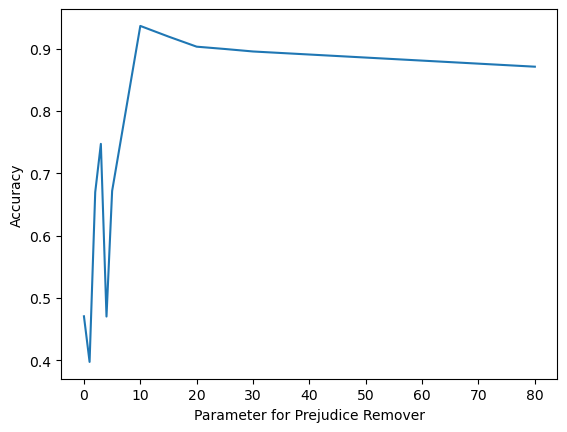

In [132]:
plt.plot(eta_value,eta_accu)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('Accuracy')
plt.show()

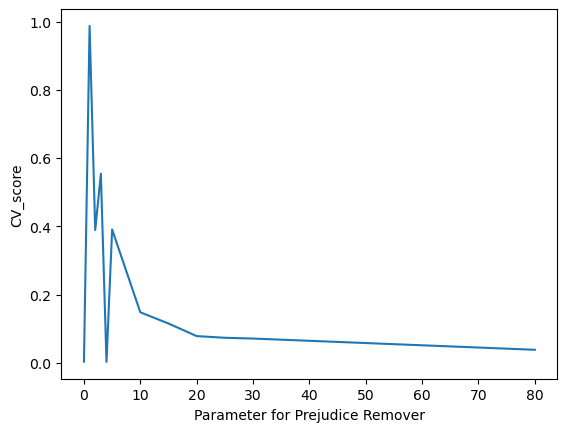

In [133]:
plt.plot(eta_value,eta_cvs)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('CV_score')
plt.show()

## student perf

In [44]:

X_train_female_st, X_test_female_st, y_train_female_st, y_test_female_st  = processing(student_perf_label, 'Family_Income', 'Exam_Score', 0)
X_train_male_st, X_test_male_st, y_train_male_st, y_test_male_st  = processing(student_perf_label, 'Family_Income', 'Exam_Score', 1)

In [48]:
#student p:
student_perf_label['Exam_Score'] = student_perf_label['Exam_Score'].astype(int)
high_f = student_perf_label[(student_perf_label['Family_Income'] == 1) & (student_perf_label['Exam_Score'] == 1)]
pf = student_perf_label[(student_perf_label['Family_Income'] == 1)]
high_m = student_perf_label[(student_perf_label['Family_Income'] == 0) & (student_perf_label['Exam_Score'] == 1)]
pm = student_perf_label[(student_perf_label['Family_Income'] == 0)]

p_c1s1 = high_f.shape[0]/pf.shape[0]
p_c1s0 = high_m.shape[0]/pm.shape[0]
p_cs = p_c1s0 - p_c1s1

print('training sample CV_score : %.4f' %( p_cs))

training sample CV_score : -0.0254


In [47]:
PR = PRLR(eta = 1.0, epochs = 3000, lr = 0.01, flag =1)
t.tensor(PR.fit(X_train_female_st,y_train_female_st,X_train_male_st,y_train_male_st)).reshape(2,1)

tensor([[0.5403],
        [0.0000]])

In [49]:
eta_value = [0.0,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0,25.0,30.0,80.0]
eta_accu = []
eta_cvs = []
for e in range(0,len(eta_value)):
  PR = PRLR(eta = eta_value[e], epochs = 3000, lr = 0.01, flag = 1)
  accv2 = t.tensor(PR.fit(X_train_female_st,y_train_female_st,X_train_male_st,y_train_male_st)).reshape(2,1)
  eta_accu.append(accv2[0].item())
  eta_cvs.append(accv2[1].item())

In [50]:
eta_accu

[0.5403000116348267,
 0.6863999962806702,
 0.5403000116348267,
 0.5403000116348267,
 0.5403000116348267,
 0.5403000116348267,
 0.5403000116348267,
 0.6029999852180481,
 0.5403000116348267,
 0.5403000116348267,
 0.5403000116348267,
 0.4788999855518341]

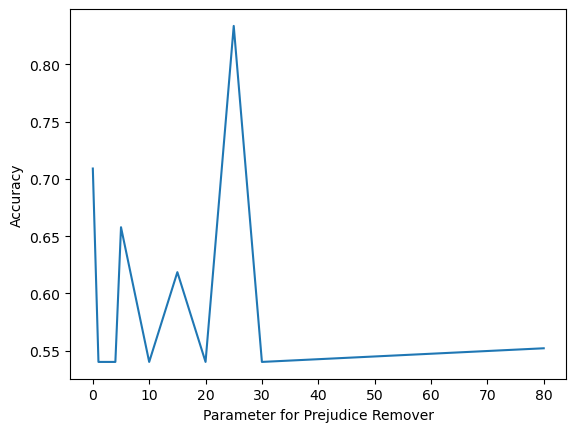

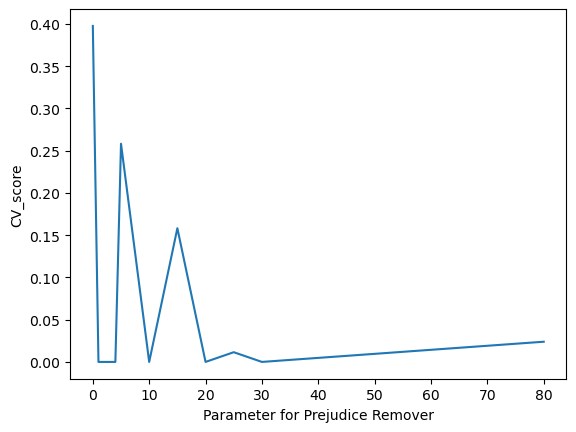

In [126]:
plt.plot(eta_value,eta_accu)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('Accuracy')
plt.show()

plt.plot(eta_value,eta_cvs)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('CV_score')
plt.show()

In [51]:
#student_perf with gender:
    
X_train_female_st, X_test_female_st, y_train_female_st, y_test_female_st  = processing(student_perf_label, 'Gender', 'Exam_Score', 0)
X_train_male_st, X_test_male_st, y_train_male_st, y_test_male_st  = processing(student_perf_label, 'Gender', 'Exam_Score', 1)



In [52]:
#student p:
student_perf_label['Exam_Score'] = student_perf_label['Exam_Score'].astype(int)
high_f = student_perf_label[(student_perf_label['Gender'] == 1) & (student_perf_label['Exam_Score'] == 1)]
pf = student_perf_label[(student_perf_label['Gender'] == 1)]
high_m = student_perf_label[(student_perf_label['Gender'] == 0) & (student_perf_label['Exam_Score'] == 1)]
pm = student_perf_label[(student_perf_label['Gender'] == 0)]

p_c1s1 = high_f.shape[0]/pf.shape[0]
p_c1s0 = high_m.shape[0]/pm.shape[0]
p_cs = p_c1s0 - p_c1s1

print('training sample CV_score : %.4f' %( p_cs))

training sample CV_score : 0.0008


In [53]:
PR = PRLR(eta = 1.0, epochs = 3000, lr = 0.01, flag =1)
t.tensor(PR.fit(X_train_female_st,y_train_female_st,X_train_male_st,y_train_male_st)).reshape(2,1)

tensor([[0.5452],
        [0.0000]])

In [54]:
eta_value = [0.0,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0,25.0,30.0,80.0]
eta_accu = []
eta_cvs = []
for e in range(0,len(eta_value)):
  print(eta_value[e])
  PR = PRLR(eta = eta_value[e], epochs = 3000, lr = 0.01, flag = 1)
  accv2 = t.tensor(PR.fit(X_train_female_st,y_train_female_st,X_train_male_st,y_train_male_st)).reshape(2,1)
  eta_accu.append(accv2[0].item())
  eta_cvs.append(accv2[1].item())

0.0
1.0
2.0
3.0
4.0
5.0
10.0
15.0
20.0
25.0
30.0
80.0


In [55]:
eta_cvs

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07329999655485153,
 0.06120000034570694,
 0.0]

In [56]:
eta_accu

[0.545199990272522,
 0.545199990272522,
 0.545199990272522,
 0.545199990272522,
 0.545199990272522,
 0.545199990272522,
 0.545199990272522,
 0.545199990272522,
 0.545199990272522,
 0.5817999839782715,
 0.574999988079071,
 0.545199990272522]

# ONE HOT

In [17]:
kiva_onehot

,funded_amount,loan_amount,partner_id,term_in_months,lender_count,country_code_AF,country_code_AL,country_code_AM,country_code_AZ,country_code_BF,...,sector_Health,sector_Housing,sector_Manufacturing,sector_Personal Use,sector_Retail,sector_Services,sector_Transportation,sector_Wholesale,borrower_genders_female,borrower_genders_male
0,300.0,300.0,247.0,12.0,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,150.0,150.0,334.0,43.0,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,200.0,200.0,247.0,11.0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,400.0,400.0,245.0,14.0,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,200.0,200.0,334.0,43.0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548111,0.0,25.0,58.0,13.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
548112,0.0,25.0,58.0,13.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
548113,25.0,25.0,138.0,13.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
548114,0.0,25.0,138.0,13.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
student_perf_onehot

,Unnamed: 0,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Motivation_Level_High,Motivation_Level_Low,...,Learning_Disabilities_No,Learning_Disabilities_Yes,Parental_Education_Level_College,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Far,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Female,Gender_Male
0,0,23,84,7,73,0,3,67,0,1,...,1,0,0,1,0,0,0,1,0,1
1,1,19,64,8,59,2,4,61,0,1,...,1,0,1,0,0,0,1,0,1,0
2,2,24,98,7,91,2,4,74,0,0,...,1,0,0,0,1,0,0,1,0,1
3,3,29,89,8,98,1,4,71,0,0,...,1,0,0,1,0,0,1,0,0,1
4,4,19,92,6,65,3,4,70,0,0,...,1,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,6602,25,69,7,76,1,2,68,0,0,...,1,0,0,1,0,0,0,1,1,0
6374,6603,23,76,8,81,3,2,69,0,0,...,1,0,0,1,0,0,0,1,1,0
6375,6604,20,90,6,65,3,2,68,0,1,...,1,0,0,0,1,0,0,1,1,0
6376,6605,10,86,6,91,2,3,68,1,0,...,1,0,0,1,0,1,0,0,1,0


In [43]:
kiva_onehot= threshold(kiva_onehot, 'loan_amount')
kiva_onehot_male = kiva_onehot.drop(columns='borrower_genders_female')
kiva_onehot_female = kiva_onehot.drop(columns='borrower_genders_male')
X_train_female_kiva, X_test_female_kiva, y_train_female_kiva, y_test_female_kiva  = processing(kiva_onehot_female, 'borrower_genders_female', 'loan_amount', 1)
X_train_male_kiva, X_test_male_kiva, y_train_male_kiva, y_test_male_kiva  = processing(kiva_onehot_male, 'borrower_genders_male', 'loan_amount', 1)

student_perf_onehot = threshold(student_perf_onehot, 'Exam_Score')
student_perf_onehot_male = student_perf_onehot.drop(columns={'Gender_Female'})
student_perf_onehot_female = student_perf_onehot.drop(columns={'Gender_Male'})
X_train_female_st, X_test_female_st, y_train_female_st, y_test_female_st  = processing(student_perf_onehot_female, 'Gender_Female', 'Exam_Score', 1)
X_train_male_st, X_test_male_st, y_train_male_st, y_test_male_st  = processing(student_perf_onehot_male, 'Gender_Male', 'Exam_Score', 1)


In [44]:
X_train_female_st.shape

torch.Size([1883, 25])

In [45]:
student_perf_onehot.shape

(6378, 27)

In [60]:
# CVscore: Calder-Verwer discrimination score
# CV score on sample data: Pr[y=1 | S=0] - Pr[y=1 | S=1]
# For sample training data

#kiva:
kiva_onehot['loan_amount'] = kiva_onehot['loan_amount'].astype(int)
high_f = kiva_onehot[(kiva_onehot['borrower_genders_female'] == 1) & (kiva_onehot['loan_amount'] == 1)]
pf = kiva_onehot[(kiva_onehot['borrower_genders_female'] == 1)]
high_m = kiva_onehot[(kiva_onehot['borrower_genders_male'] == 1) & (kiva_onehot['loan_amount'] == 1)]
pm = kiva_onehot[(kiva_onehot['borrower_genders_male'] == 1)]

p_c1s1 = high_f.shape[0]/pf.shape[0]
p_c1s0 = high_m.shape[0]/pm.shape[0]
p_cs = p_c1s0 - p_c1s1

print('training sample CV_score : %.4f' %( p_cs))

training sample CV_score : 0.2092


In [61]:
X_train_female_kiva_sample = X_train_female_kiva
y_train_female_kiva_sample = y_train_female_kiva
X_train_male_kiva_sample = X_train_male_kiva
y_train_male_kiva_sample = y_train_male_kiva
eta_accu = []
eta_cvs = []
eta_value = [0.0,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0,25.0,30.0,80.0]
for e in range(0,len(eta_value)):
  PR = PRLR(eta = eta_value[e], epochs = 3000, lr = 0.01, flag = 0)
  accv2 = t.tensor(PR.fit(X_train_female_kiva_sample,y_train_female_kiva_sample,X_train_male_kiva_sample,y_train_male_kiva_sample)).reshape(2,1)
  eta_accu.append(accv2[0].item())
  eta_cvs.append(accv2[1].item())
  print(e)

0
1
2
3
4
5
6
7
8
9
10
11


In [59]:
eta_cvs

[0.414000004529953, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

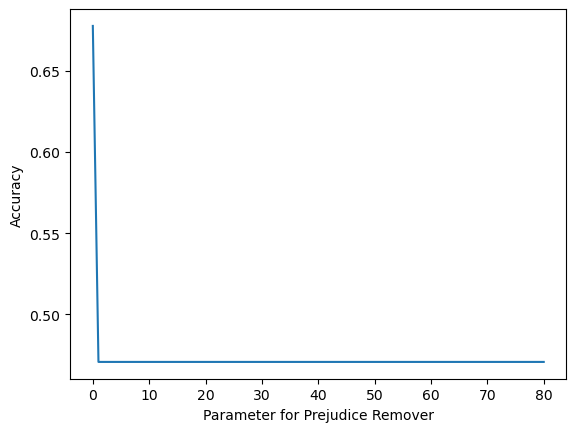

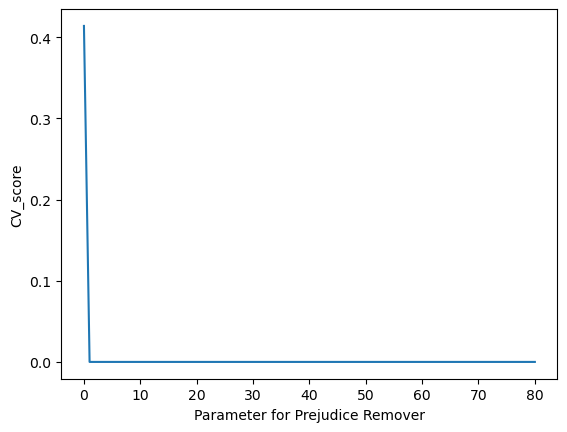

In [58]:
plt.plot(eta_value,eta_accu)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('Accuracy')
plt.show()

plt.plot(eta_value,eta_cvs)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('CV_score')
plt.show()

In [52]:
#student perf:
# CVscore: Calder-Verwer discrimination score
# CV score on sample data: Pr[y=1 | S=0] - Pr[y=1 | S=1]
# For sample training data

#kiva:
student_perf_onehot['Exam_Score'] = student_perf_onehot['Exam_Score'].astype(int)
high_f = student_perf_onehot[(student_perf_onehot['Gender_Female'] == 1) & (student_perf_onehot['Exam_Score'] == 1)]
pf = student_perf_onehot[(student_perf_onehot['Gender_Female'] == 1)]
high_m = student_perf_onehot[(student_perf_onehot['Gender_Male'] == 1) & (student_perf_onehot['Exam_Score'] == 1)]
pm = student_perf_onehot[(student_perf_onehot['Gender_Male'] == 1)]

p_c1s1 = high_f.shape[0]/pf.shape[0]
p_c1s0 = high_m.shape[0]/pm.shape[0]
p_cs = p_c1s0 - p_c1s1

print('training sample CV_score : %.4f' %( p_cs))

training sample CV_score : -0.0008


In [55]:
eta_value = [0.0,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0,25.0,30.0,80.0]
eta_accu = []
eta_cvs = []
for e in range(0,len(eta_value)):
  print(eta_value[e])
  PR = PRLR(eta = eta_value[e], epochs = 3000, lr = 0.01, flag = 1)
  accv2 = t.tensor(PR.fit(X_train_female_st,y_train_female_st,X_train_male_st,y_train_male_st)).reshape(2,1)
  eta_accu.append(accv2[0].item())
  eta_cvs.append(accv2[1].item())

0.0
1.0
2.0
3.0
4.0
5.0
10.0
15.0
20.0
25.0
30.0
80.0


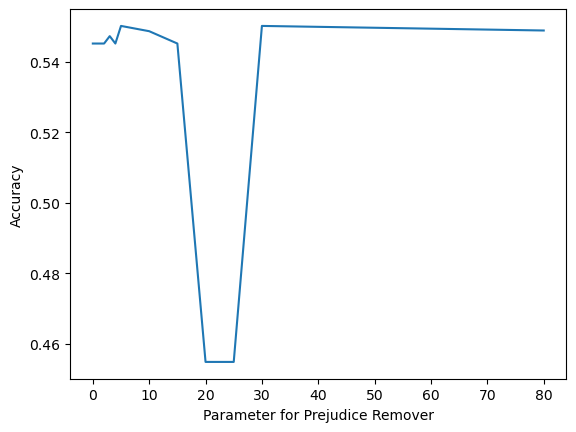

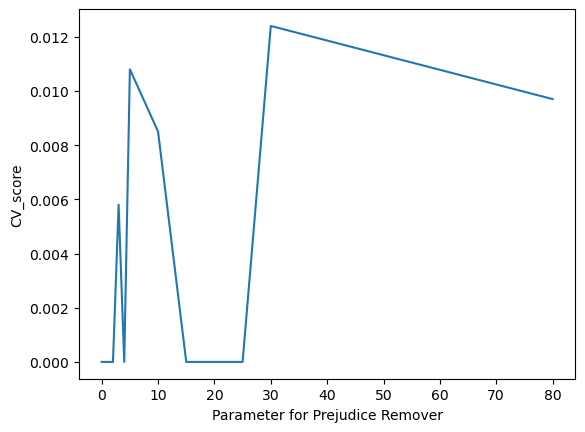

In [56]:
plt.plot(eta_value,eta_accu)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('Accuracy')
plt.show()

plt.plot(eta_value,eta_cvs)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('CV_score')
plt.show()

# Dropping sensitive feature with label encoding

## KIVA

In [26]:
kiva_label.head()

,funded_amount,loan_amount,sector,country_code,currency,partner_id,term_in_months,lender_count,borrower_genders,repayment_interval
0,300.0,0,6,51,39,247.0,12.0,12,0,1
1,150.0,0,13,27,19,334.0,43.0,6,0,0
2,200.0,0,1,51,39,247.0,11.0,8,0,1
3,400.0,0,6,51,39,245.0,14.0,16,0,2
4,200.0,0,0,27,19,334.0,43.0,8,0,0


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = kiva_label.drop(columns={'borrower_genders', 'loan_amount'})
y = kiva_label['loan_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


/Users/mihikaghaisas/miniforge3/envs/test1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
X_gender = kiva_label.drop(columns={'loan_amount'})
X_train, X_test, y_train, y_test = train_test_split(X_gender, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


/Users/mihikaghaisas/miniforge3/envs/test1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## STUDENT PERF

In [33]:
student_perf_label.head()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,7,73,1,0,0,2,3,0,1,2,1,0
1,19,64,8,59,1,2,1,2,4,0,0,1,0,0
2,24,98,7,91,2,2,1,2,4,0,2,2,1,1
3,29,89,8,98,2,1,1,2,4,0,1,1,1,1
4,19,92,6,65,2,3,1,0,4,0,0,2,0,1


In [35]:
X = student_perf_label.drop(columns={'Gender', 'Exam_Score'})
y = student_perf_label['Exam_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


/Users/mihikaghaisas/miniforge3/envs/test1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
X_gender = student_perf_label.drop(columns={'Exam_Score'})
X_train, X_test, y_train, y_test = train_test_split(X_gender, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


/Users/mihikaghaisas/miniforge3/envs/test1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
X = student_perf_label.drop(columns={'Family_Income', 'Exam_Score'})
y = student_perf_label['Exam_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.85


/Users/mihikaghaisas/miniforge3/envs/test1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Adding a dummy column 

In [105]:
kiva_dummy = kiva_label
kiva_dummy['Sensitive'] = np.append(np.zeros(kiva_dummy.shape[0]-2), np.ones(2), axis = 0)
X_train_female_kiva, X_test_female_kiva, y_train_female_kiva, y_test_female_kiva  = processing(kiva_dummy, 'Sensitive', 'loan_amount', 0)
X_train_male_kiva, X_test_male_kiva, y_train_male_kiva, y_test_male_kiva  = processing(kiva_dummy, 'Sensitive', 'loan_amount', 1)

student_perf_dummy = student_perf_label
student_perf_dummy['Sensitive'] = np.append(np.zeros(student_perf_dummy.shape[0]-2), np.ones(2), axis = 0)
X_train_female_st, X_test_female_st, y_train_female_st, y_test_female_st  = processing(student_perf_dummy, 'Sensitive', 'Exam_Score', 0)
X_train_male_st, X_test_male_st, y_train_male_st, y_test_male_st  = processing(student_perf_dummy, 'Sensitive', 'Exam_Score', 1)
print(X_train_female_kiva.shape)

torch.Size([383679, 10])


In [106]:
# Define a logistic regression model using PyTorch's nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, flag=0):
        # Call the parent constructor to initialize the nn.Module
        super(LogisticRegression, self).__init__()

        # Define a linear transformation layer (weights and bias) for the model.
        # `x_test_female.shape[1]` specifies the number of input features, and `out_features=1` indicates a single output for binary classification.
        # The bias term is included by setting bias=True, allowing the model to learn an intercept.
        self.flag= flag
        self.w =0
        if self.flag == 0:
            self.w = nn.Linear(X_train_female_kiva.shape[1], out_features=1, bias=True)
        else:
            self.w = nn.Linear(X_train_female_st.shape[1], out_features=1, bias=True)
        

        # Initialize a sigmoid activation function, which will be used to convert logits to probabilities.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Define the forward pass for the model.
        # Apply the linear transformation to the input `x`.
        w = self.w(x)

        # Apply the sigmoid function to the output of the linear layer.
        # This converts the logits (raw output of the linear layer) to probabilities in the range (0, 1).
        output = self.sigmoid(w)

        # Return the output probabilities.
        return output

In [107]:
class PRLoss():  # Define a class for the probabilistic loss function
    def __init__(self, eta=1.0, flag=0):
        # Initialize the class with a scaling factor eta.
        # The eta parameter can be used to adjust the magnitude of the loss.
        super(PRLoss, self).__init__()
        self.eta = eta  # Set the eta value for scaling the loss.
        self.flag = flag  # Set the flag value, default is 0.


    def forward(self, output_f, output_m):
       

        # The forward method computes the loss based on the outputs for females (output_f) and males (output_m).
        
        # Calculate the number of female and male samples
        N_female = t.tensor(output_f.shape[0])  # Number of female samples
        N_male = t.tensor(output_m.shape[0])      # Number of male samples
        
        # Stack the number of samples for males and females into a tensor
        Dxisi = t.stack((N_male, N_female), axis=0)  # Tensor with shape [2] containing male and female counts

        # Calculate the predicted probabilities for females and males
        y_pred_female = t.sum(output_f)  # Sum of predicted probabilities for females
        y_pred_male = t.sum(output_m)      # Sum of predicted probabilities for males
        
        # Calculate conditional probabilities Pr[y|s]
        P_ys = t.stack((y_pred_male, y_pred_female), axis=0) / Dxisi
        # P_ys now contains the probabilities of y given the gender (s)

        # Calculate overall probability Pr[y]
        P = t.cat((output_f, output_m), 0)  # Concatenate female and male predictions
        P_y = 0
        if self.flag == 0: #kiva dataset
            P_y = t.sum(P) / (X_train_female_kiva.shape[0] + X_train_male_kiva.shape[0])  # Overall probability of y
        else:
            P_y = t.sum(P) / (X_train_female_st.shape[0] + X_train_male_st.shape[0])  # Overall probability of y
        # Calculate the individual terms needed for the loss
        P_s1y1 = t.log(P_ys[1]) - t.log(P_y)  # Log probability for female given positive class
        P_s1y0 = t.log(1 - P_ys[1]) - t.log(1 - P_y)  # Log probability for female given negative class
        P_s0y1 = t.log(P_ys[0]) - t.log(P_y)  # Log probability for male given positive class
        P_s0y0 = t.log(1 - P_ys[0]) - t.log(1 - P_y)  # Log probability for male given negative class

        # Calculate the individual contributions to the loss
        PI_s1y1 = output_f * P_s1y1  # Contribution from female samples in positive class
        PI_s1y0 = (1 - output_f) * P_s1y0  # Contribution from female samples in negative class
        PI_s0y1 = output_m * P_s0y1  # Contribution from male samples in positive class
        PI_s0y0 = (1 - output_m) * P_s0y0  # Contribution from male samples in negative class

        # Sum all contributions to get the final loss
        PI = t.sum(PI_s1y1) + t.sum(PI_s1y0) + t.sum(PI_s0y1) + t.sum(PI_s0y0)
        PI = self.eta * PI  # Scale the loss by eta

        return PI  # Return the computed loss


In [111]:

PR = PRLR(eta = 1.0, epochs = 3000, lr = 0.01, flag =1)
t.tensor(PR.fit(X_train_female_kiva,y_train_female_kiva,X_train_male_kiva,y_train_male_kiva)).reshape(2,1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (383679x10 and 14x1)

In [85]:
X_train_female_kiva.shape

torch.Size([383679, 10])

In [86]:
X_train_male_kiva.shape

torch.Size([1, 10])

In [ ]:

PR = PRLR(eta = 1.0, epochs = 3000, lr = 0.01, flag =1)
t.tensor(PR.fit(X_train_female_st,y_train_female_st,X_train_male_st,y_train_male_st)).reshape(2,1)